In [67]:
import polars as pl
import numpy as np
from datasets import load_from_disk

In [68]:
valid_data = load_from_disk("../../trained_models/e027-gemma-no-frz-gemma-2-9b-it-bnb-4bit/valid_dataset")
valid_pred = np.load("../../trained_models/e027-gemma-no-frz-gemma-2-9b-it-bnb-4bit/valid_prediction.npy")

In [69]:
valid_pred_idx = valid_pred.argmax(axis=1)

In [70]:
valid_pred_idx_df = pl.DataFrame(
    valid_pred_idx,
    schema=["valid_pred_idx"]
)

In [71]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("../../trained_models/e027-gemma-no-frz-gemma-2-9b-it-bnb-4bit/")
tokenizer.add_eos_token = True  # We'll add <eos> at the end
tokenizer.padding_side = "right"

In [72]:
def decode_tokenize(input_ids):
    return tokenizer.decode(input_ids)

In [73]:
valid_df = valid_data.to_polars()

In [74]:
valid_df = valid_df.with_columns(
    pl.col("input_ids").map_elements(decode_tokenize, return_dtype=pl.String).alias("decoded_text")
)

In [75]:
valid_pred_df = pl.DataFrame(
    valid_pred,
    schema=["winner_a", "winner_b", "tie"]
)

In [76]:
(
    pl.concat(
        [valid_df, valid_pred_df, valid_pred_idx_df],
        how="horizontal"
    )
    .select(
        pl.exclude("input_ids", "valid_pred", "attention_mask")
    )
    .head(1000)
    .write_csv("e027_err_analysis.csv")
)

In [80]:
from sklearn.metrics import precision_score, recall_score

# 各クラスのPrecisionとRecallを計算
precision = precision_score(valid_data["labels"], valid_pred_idx, average=None)
recall = recall_score(valid_data["labels"], valid_pred_idx, average=None)

print("Precision:", precision)
print("Recall:", recall)

Precision: [0.57575758 0.54353339 0.50412088]
Recall: [0.6        0.62548638 0.39590076]


In [81]:
from collections import Counter
Counter(valid_data["labels"])

Counter({0: 1045, 1: 1028, 2: 927})

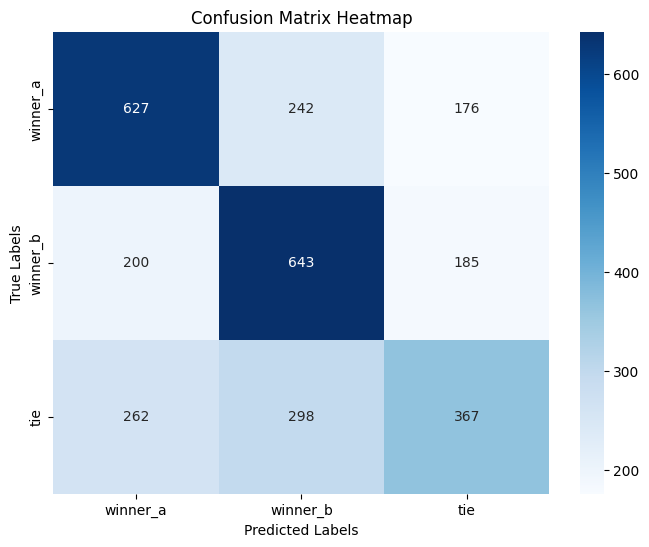

In [84]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

conf_matrix = confusion_matrix(valid_data["labels"], valid_pred_idx)

# ラベルを定義
labels = ['winner_a', 'winner_b', 'tie']

# 混同行列をヒートマップとしてプロット
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Heatmap')
plt.show()

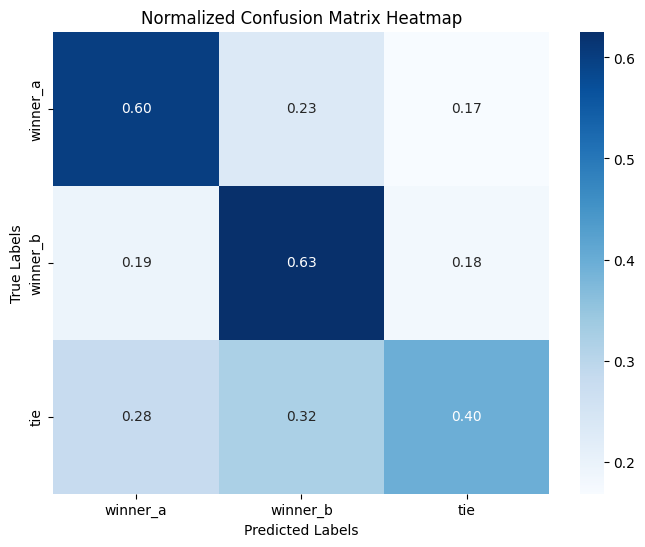

In [85]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

conf_matrix = confusion_matrix(valid_data["labels"], valid_pred_idx)

# 混同行列を割合に変換
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# ラベルを定義
labels = ['winner_a', 'winner_b', 'tie']

# 混同行列をヒートマップとしてプロット
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_normalized, annot=True, fmt=".2f", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Normalized Confusion Matrix Heatmap')
plt.show()